## Compare LM Uncertainty over a token with it's prominence 

In [27]:
import numpy as np
import os
from src.data.components.helsinki import HelsinkiProminenceExtractor
from src.data.components.datasets import TokenTaggingDataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch
import json

In [28]:
DATA_DIR = "/Users/lukas/Desktop/projects/MIT/MIT_prosody/data/Helsinki"

DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"
DEVICE = "cuda" if torch.cuda.is_available() else DEVICE
print(f"Using device: {DEVICE}")

Using device: mps


#### Create dataloader with the prominence labels 

In [29]:
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained("gpt2", add_prefix_space=True)
tokenizer.pad_token_id = tokenizer.eos_token_id

In [30]:
train_extractor = HelsinkiProminenceExtractor(
    DATA_DIR,
    "train_360.txt",
)
train_texts = train_extractor.get_all_texts()
train_prominences = train_extractor.get_all_real_prominence()

test_extractor = HelsinkiProminenceExtractor(
    DATA_DIR,
    "test.txt",
)
test_texts = test_extractor.get_all_texts()
test_prominences = test_extractor.get_all_real_prominence()

print(f"train_texts: {len(train_texts)}, test_texts: {len(test_texts)}")
test_texts[:3]

train_texts: 116263, test_texts: 4822


['He hoped there would be stew for dinner , turnips and carrots and bruised potatoes and fat mutton pieces to be ladled out in thick peppered flour fattened sauce . Stuff it into you , his belly counselled him .',
 'It would be a gloomy secret night .',
 'After early nightfall the yellow lamps would light up , here and there , the squalid quarter of the brothels .']

In [31]:
from src.utils.text_processing import python_lowercase
from src.utils.text_processing import python_lowercase_remove_punctuation

# train_texts = [python_lowercase(text) for text in train_texts]
# test_texts = [python_lowercase(text) for text in test_texts]
train_texts = [python_lowercase_remove_punctuation(text) for text in train_texts]
test_texts = [python_lowercase_remove_punctuation(text) for text in test_texts]
test_texts[:3]

['he hoped there would be stew for dinner  turnips and carrots and bruised potatoes and fat mutton pieces to be ladled out in thick peppered flour fattened sauce  stuff it into you  his belly counselled him ',
 'it would be a gloomy secret night ',
 'after early nightfall the yellow lamps would light up  here and there  the squalid quarter of the brothels ']

In [32]:
train_texts = [text.replace(" . ", " ") for text in train_texts]
test_texts = [text.replace(" .", ".") for text in test_texts]

train_texts[:3]

['for man of you  your characteristic race  here may he hardy  sweet  gigantic grow  here tower proportionate to nature  here climb the vast pure spaces unconfined  uncheckd by wall or roof  here laugh with storm or sun  here joy  here patiently inure  here heed himself  unfold himself  not others formulas heed  here fill his time  to duly fall  to aid  at last  to disappear  to serve ',
 'tom  the pipers son',
 'tom  tom  the pipers son  stole a pig and away he run  the pig was eat and tom was beat and tom ran crying down the street ']

In [33]:
train_dataset = TokenTaggingDataset(
    train_texts,
    train_prominences,
    tokenizer,
    "gpt2",
    score_first_token=True,
    # relative_to_prev=False,
    # n_prev=3,
    # relative_to_mean=True,
    # word_stats=word_stats,
)

test_dataset = TokenTaggingDataset(
    test_texts,
    test_prominences,
    tokenizer,
    "gpt2",
    score_first_token=True,
    # relative_to_prev=False,
    # n_prev=3,
    # relative_to_mean=True,
    # word_stats=word_stats,
)

Preprocessing samples: 100%|██████████| 116263/116263 [00:52<00:00, 2195.08it/s]


Failed 9869/116263


Preprocessing samples: 100%|██████████| 4822/4822 [00:03<00:00, 1334.40it/s]

Failed 398/4822


In [34]:
train_texts = []
train_labels = []
train_input_ids = []
train_word_to_token = []
train_loss_masks = []

for i in tqdm(range(len(train_dataset)), desc="train", total=len(train_dataset)):
    item = train_dataset.__getitem__(i)
    train_texts.append(item["input_text"])
    train_input_ids.append(item["input_ids"])
    train_word_to_token.append(item["word_to_tokens"])
    train_loss_masks.append(item["loss_mask"])
    loss_mask = np.array(item["loss_mask"])
    labels = np.array(item["tokenized_labels"])
    valid_labels = np.array(labels[loss_mask == 1])
    train_labels.append(valid_labels)

test_texts = []
test_labels = []
test_input_ids = []
test_word_to_token = []
test_loss_masks = []

for i in tqdm(range(len(test_dataset)), desc="test", total=len(test_dataset)):
    item = test_dataset.__getitem__(i)
    test_texts.append(item["input_text"])
    test_input_ids.append(item["input_ids"])
    test_word_to_token.append(item["word_to_tokens"])
    test_loss_masks.append(item["loss_mask"])
    loss_mask = np.array(item["loss_mask"])
    labels = np.array(item["tokenized_labels"])
    valid_labels = np.array(labels[loss_mask == 1])
    test_labels.append(valid_labels)

test: 100%|██████████| 4424/4424 [00:00<00:00, 189255.96it/s]


In [11]:
len(test_labels[0])

36

In [12]:
len(train_labels), len(test_labels)

(106394, 4424)

In [13]:
from src.data.components.collators import collate_fn


def collate(batch):
    return collate_fn(batch, tokenizer.pad_token_id)


dataloader = DataLoader(
    test_dataset, batch_size=16, shuffle=False, num_workers=0, collate_fn=collate
)

In [14]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from src.utils.stats import shannon_entropy

# Load pre-trained GPT-2 model and tokenizer
model_name = "gpt2"
model = GPT2LMHeadModel.from_pretrained(model_name).to(DEVICE)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Set model to evaluation mode
model.eval()

# Your given inputs
# test_texts = ["your text here", "another text"]
# test_input_ids = [tokenizer.encode(text, return_tensors="pt") for text in test_texts]

# Store probabilities for each token in each sentence
token_probabilities = []
token_entropies = []
token_surprisal = []
tokens = []

# Iterate through tokenized input ids
for i, input_ids in tqdm(
    enumerate(train_input_ids[: int(len(train_input_ids) / 40)]),
    total=len(train_input_ids[: int(len(train_input_ids) / 40)]),
):
    # print(f"text: {test_texts[i]}")
    # print(f"input_ids: {input_ids}")

    # Get the model's output
    with torch.no_grad():
        outputs = model(torch.tensor(input_ids).to(DEVICE))

    # print(f"inputs shape {torch.tensor(input_ids).shape}")

    # Extract logits from the output
    logits = outputs.logits
    logits = logits.squeeze(0)
    # print(f"logits shape {logits.shape}")
    # print(f"sum along dim 1 {torch.sum(logits, dim=1)}")

    # Calculate probabilities from logits
    probabilities = torch.softmax(logits, dim=-1)

    # print(f"probabilities shape {probabilities.shape}")

    # Get probabilities for the desired token
    if len(input_ids) == 1:
        sequence_probabilities = torch.tensor([probabilities[input_ids[0]]])
        sequence_surprisal = -torch.log2(sequence_probabilities)
        entropies = shannon_entropy(probabilities.unsqueeze(0))
    else:
        sequence_probabilities = torch.stack(
            [probabilities[i, token_id] for i, token_id in enumerate(input_ids)]
        )
        sequence_surprisal = -torch.log2(sequence_probabilities)
        entropies = shannon_entropy(probabilities)
    # print(f"sequence_probabilities shape {sequence_probabilities.shape}")

    # Convert tensor to list and append to the main list
    token_probabilities.append(sequence_probabilities)
    token_surprisal.append(sequence_surprisal)
    tokens.append(input_ids)
    token_entropies.append(entropies)

# print(token_probabilities)

100%|██████████| 2659/2659 [02:28<00:00, 17.95it/s]


In [15]:
import numpy as np
from scipy.stats import spearmanr, pearsonr

# Flatten train_token_probabilities and train_labels into lists
flat_train_token_probabilities = []
flat_train_token_surprisals = []
flat_train_token_surprisal = []
flat_train_token_entropies = []
flat_train_labels = []
flat_train_tokens = []
flat_train_texts = []

for i, seq in enumerate(token_probabilities):
    # print(f"seq shape: {seq.shape}")
    valid_probs = torch.squeeze(seq[torch.tensor(train_loss_masks[i]) == 1])
    valid_surprisals = torch.squeeze(
        token_surprisal[i][torch.tensor(train_loss_masks[i]) == 1]
    )
    valid_surprisals = torch.tensor(token_surprisal[i])[
        torch.tensor(train_loss_masks[i]) == 1
    ]
    valid_entropies = torch.tensor(token_entropies[i])[
        torch.tensor(train_loss_masks[i]) == 1
    ]

    if len(valid_probs.shape) == 0:
        continue
    if len(valid_probs) > 0:
        flat_train_token_probabilities.extend(valid_probs[3:])
        flat_train_token_surprisal.extend(valid_surprisals[3:])
        flat_train_token_entropies.extend(valid_entropies[3:])
        flat_train_labels.extend(train_labels[i][3:])
        valid_tokens = torch.tensor(tokens[i])[torch.tensor(train_loss_masks[i]) == 1]
        flat_train_tokens.extend(valid_tokens[3:])
        flat_train_texts.extend([train_texts[i]])

# Convert lists to numpy arrays
flat_train_token_probabilities = np.array(flat_train_token_probabilities)
flat_train_token_surprisal = np.array(flat_train_token_surprisal)
flat_train_labels = np.array(flat_train_labels)
flat_train_token_entropies = np.array(flat_train_token_entropies)

# convert probabilities to log probabilities
flat_train_token_probabilities = np.log(flat_train_token_probabilities)

/var/folders/hg/k29n8l193w76mcsdz5qf1w5h0000gn/T/ipykernel_71084/1274143338.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valid_surprisals = torch.tensor(token_surprisal[i])[


(36954,) (36954,)
(36953,) (36953,)
Train Entropy and prominence: Spearman's rank correlation coefficient: -0.014347449642551871
Train Entropy and prominence: Pearson's correlation coefficient: -0.021125287146667674
(36954,) (36954,)
(36953,) (36953,)
Train Surprisal and prominence: Spearman's rank correlation coefficient: 0.04855076619148193
Train Surprisal and prominence: Pearson's correlation coefficient: 0.03996704457160992


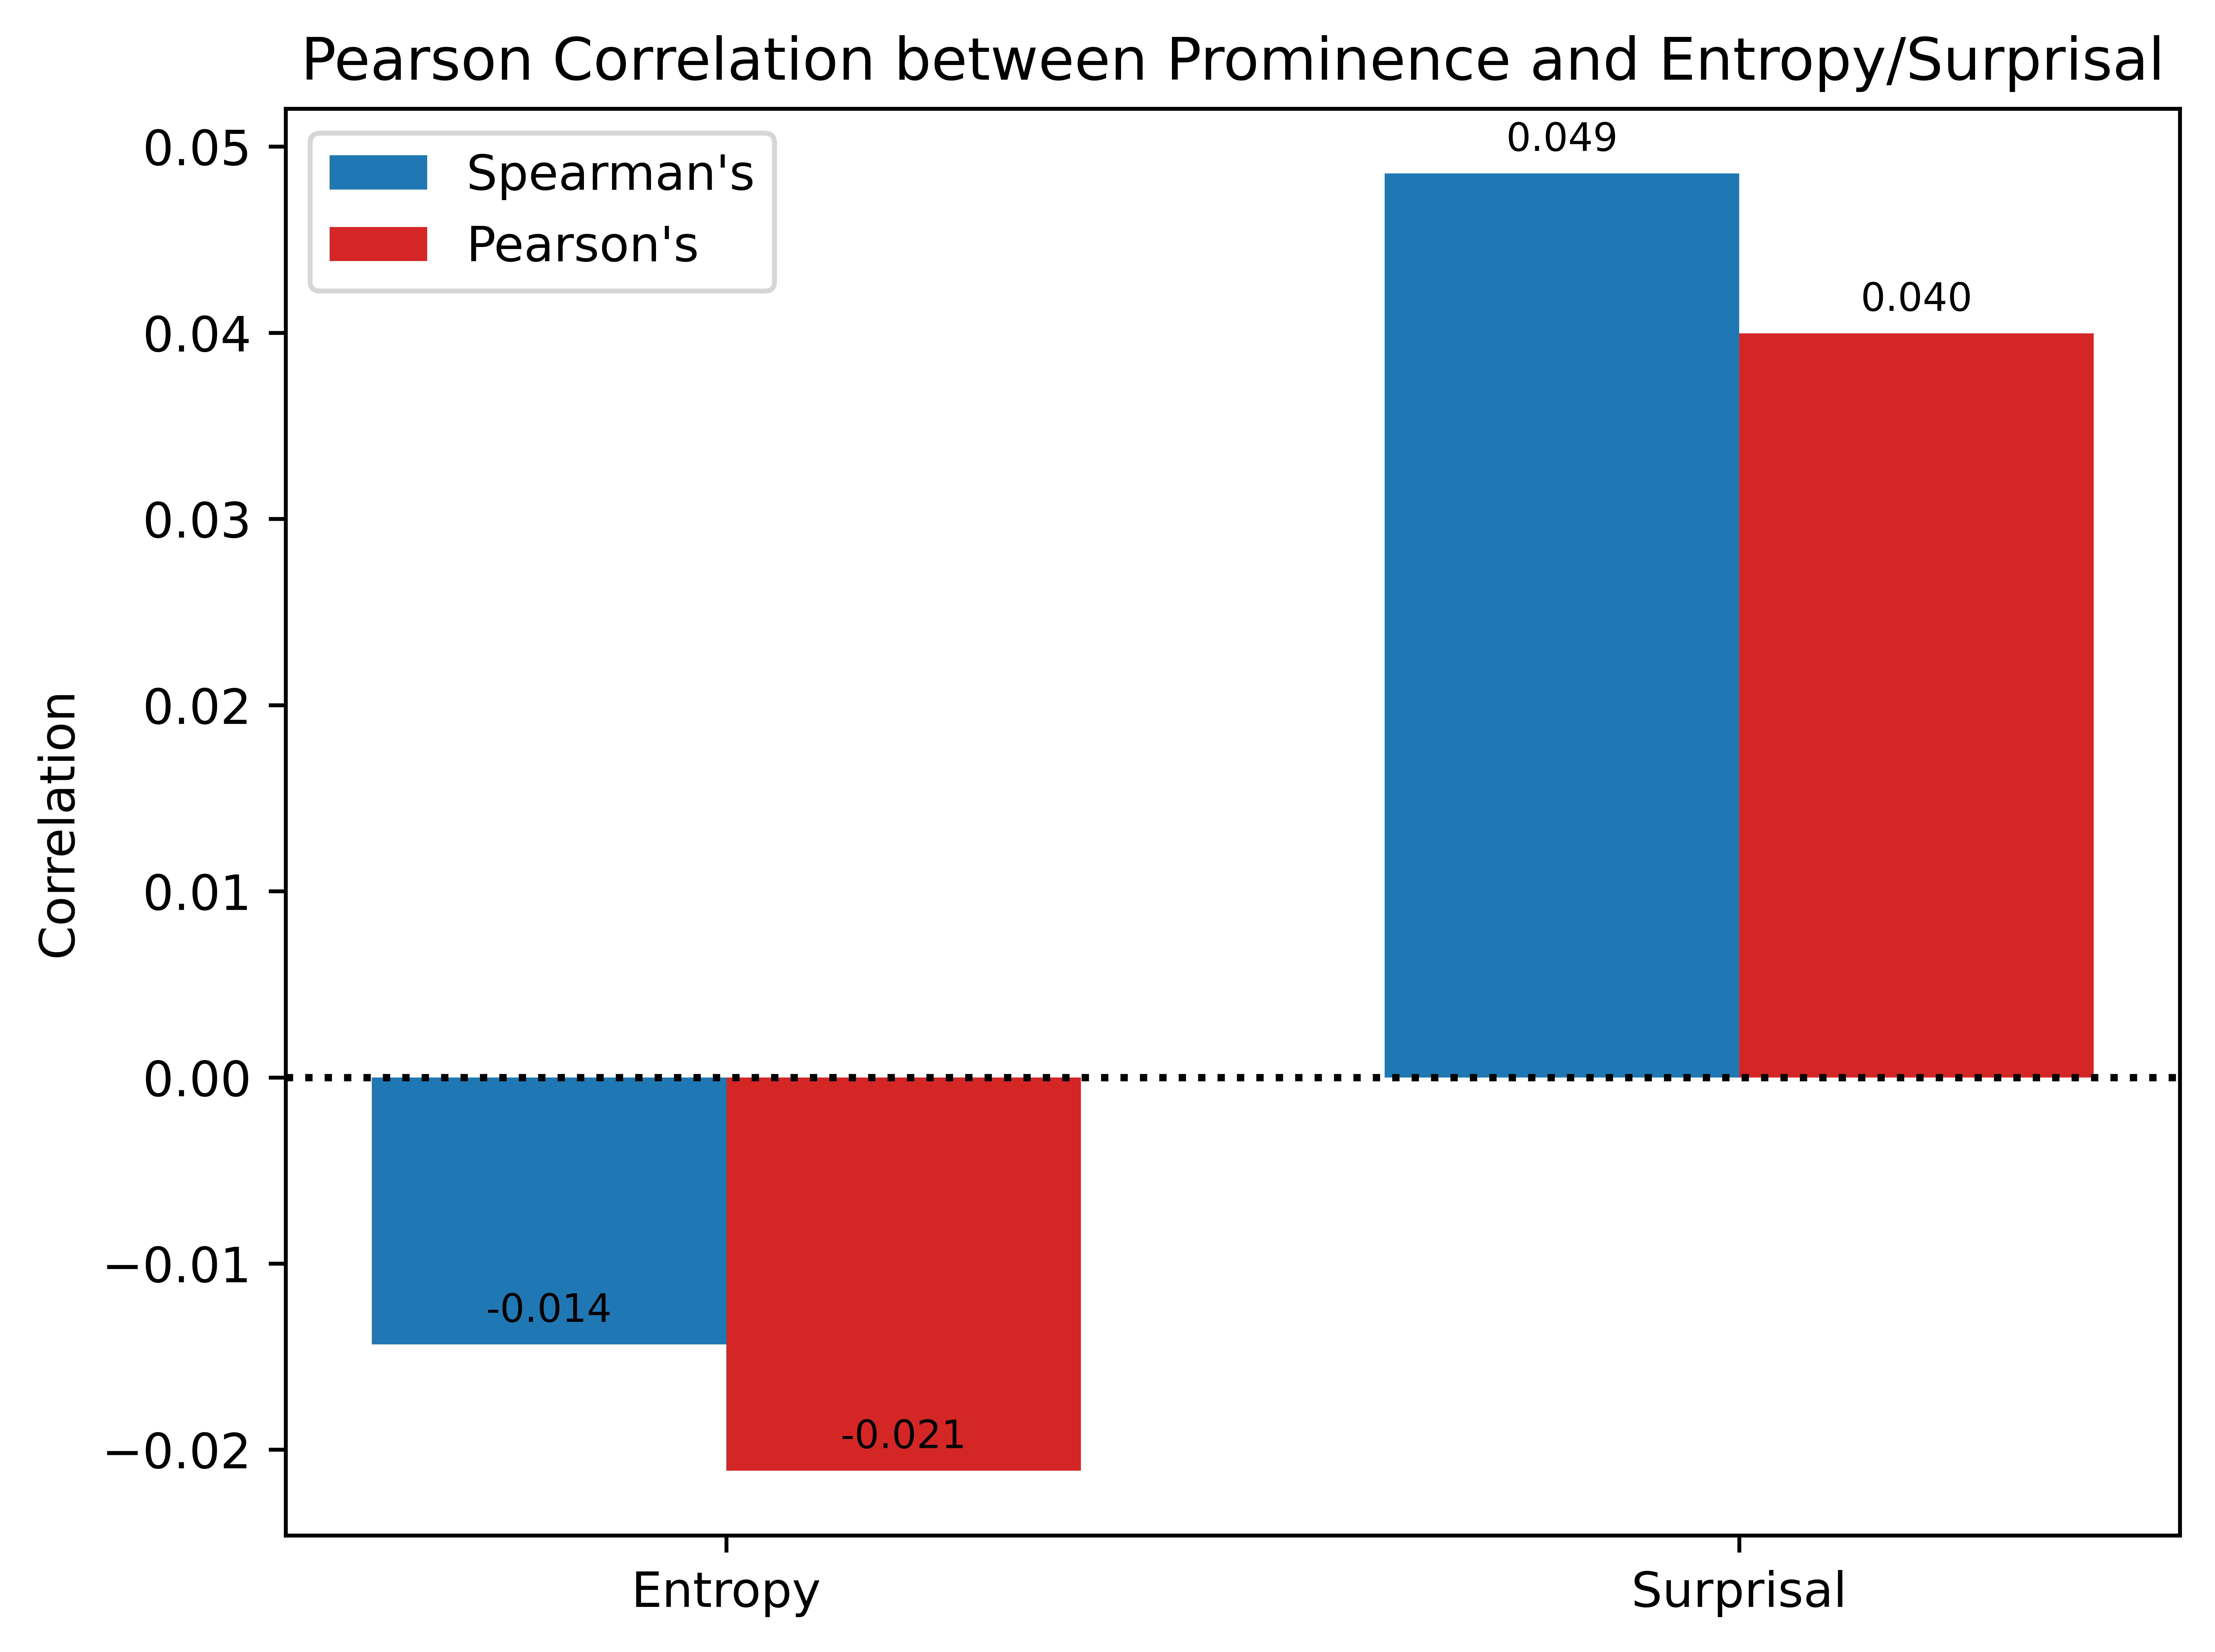

In [16]:
from scipy.stats import spearmanr, pearsonr
from src.utils.plots import plot_correlations

# Calculate correlations and store them in lists
spearman_correlations = []
pearson_correlations = []

for feature, data in zip(
    ["Entropy", "Surprisal"],
    [
        flat_train_token_entropies,
        flat_train_token_surprisal,
    ],
):
    print(data.shape, flat_train_labels.shape)
    print(data[:-1].shape, flat_train_labels[1:].shape)
    if feature == "Entropy":
        # Calculate Spearman's rank correlation coefficient
        spearman_corr, _ = spearmanr(data[:-1], flat_train_labels[1:])
        spearman_correlations.append(spearman_corr)

        # Calculate Pearson's correlation coefficient
        pearson_corr, _ = pearsonr(data[:-1], flat_train_labels[1:])
        pearson_correlations.append(pearson_corr)
    elif feature == "Surprisal":
        # Calculate Spearman's rank correlation coefficient
        spearman_corr, _ = spearmanr(data, flat_train_labels)
        spearman_correlations.append(spearman_corr)

        # Calculate Pearson's correlation coefficient
        pearson_corr, _ = pearsonr(data, flat_train_labels)
        pearson_correlations.append(pearson_corr)

    print(
        f"Train {feature} and prominence: Spearman's rank correlation coefficient: {spearman_corr}"
    )
    print(
        f"Train {feature} and prominence: Pearson's correlation coefficient: {pearson_corr}"
    )

# Call the function with the lists of feature labels, Spearman correlations, and Pearson correlations
feature_labels = ["Entropy", "Surprisal"]
plot_correlations(
    feature_labels,
    spearman_correlations,
    pearson_correlations,
    title="Pearson Correlation between Prominence and Entropy/Surprisal",
)

In [17]:
# Calculate Spearman's rank correlation coefficient
spearman_corr, _ = spearmanr(
    flat_train_token_entropies[:-1], flat_train_token_surprisal[1:]
)

# Calculate Pearson's correlation coefficient
pearson_corr, _ = pearsonr(
    flat_train_token_entropies[:-1], flat_train_token_surprisal[1:]
)

print(
    f"Train Spearman's rank correlation coefficient between entropy and surprisal: {spearman_corr}"
)
print(
    f"Train Pearson's correlation coefficient between entropy and surprisal: {pearson_corr}"
)

Train Spearman's rank correlation coefficient between entropy and surprisal: -0.11685898647084274
Train Pearson's correlation coefficient between entropy and surprisal: -0.1155064041752055


In [18]:
# Autocorrelation of the prominences

import numpy as np


def autocorrelation(input_array):
    # Subtract the mean and normalize the data to its standard deviation
    normalized_array = (input_array - np.mean(input_array)) / np.std(input_array)

    # Compute autocorrelation using numpy correlate function
    autocorrelation = np.correlate(normalized_array, normalized_array, mode="full")

    # Only take second half because the first half is the same due to symmetry
    autocorrelation = autocorrelation[autocorrelation.size // 2 :]

    return autocorrelation


# Test the function
autocorr = autocorrelation(flat_train_labels)
autocorr

array([ 3.69540000e+04, -6.75319920e+03, -1.14574581e+03, ...,
       -4.36429643e-01, -1.52844646e-01, -2.04761651e-02])

In [33]:
norm = np.linalg.norm(flat_train_labels)
labels_normalized = flat_train_labels / norm
autocorrelation(labels_normalized)

array([ 3.51390000e+04, -6.40665961e+03, -1.10326278e+03, ...,
       -1.35153000e+00, -2.97359388e-01, -1.20195325e-02])

In [34]:
# iterate over the token probabilities and tokens, and store the pairs of the decoded text and probabilities

from src.utils.text_processing import python_remove_whitespace

word_prob_entropy_prominence = []
for i, seq in enumerate(flat_train_token_probabilities):
    text = python_remove_whitespace(tokenizer.decode([flat_train_tokens[i]]))
    word_prob_prominence.append(
        (text, seq, flat_train_token_entropies[i], flat_train_labels[i])
    )

NameError: name 'word_prob_prominence' is not defined

In [ ]:
flat_train_token_probabilities

array([5.1829210e-03, 2.3275774e-05, 2.2758635e-04, ..., 1.6334360e-06,
       2.7495442e-04, 9.8591881e-06], dtype=float32)

In [ ]:
word_prob_entropy_prominence

[]

In [ ]:
import pandas as pd

word_stats_path = (
    "/Users/lukas/Desktop/projects/MIT/MIT_prosody/notebooks/word_to_stats_uncased.csv"
)
word_stats = pd.read_csv(word_stats_path)
word_stats.head()

,word,count,mean,std,min,max
0,marm,2,2.8245,2.192500,0.632,5.017
1,ostensible,2,2.8300,2.080000,0.750,4.910
2,roderick,4,1.6385,2.034932,0.165,5.138
3,fieldfare,2,2.9715,1.973500,0.998,4.945
4,sarkoja,2,2.4540,1.897000,0.557,4.351


### High mean prominence words

In [ ]:
# sort by mean and compute correlation coefficients of the top 1000 with count >= 3
word_stats.sort_values(by="mean", ascending=False, inplace=True)

word_stats_high_mean = word_stats[word_stats["count"] >= 3]
word_stats_high_mean = word_stats_high_mean[:1000]
print(len(word_stats_high_mean))
word_stats_high_mean.head()

1000


,word,count,mean,std,min,max
17567,hoo,3,4.067333,0.541291,3.374,4.695
4454,empathetic,3,3.513667,0.823731,2.356,4.205
25241,vassilyevitch,3,3.424667,0.283828,3.098,3.790
27357,eruct,4,3.266750,0.171081,3.023,3.496
22268,oho,3,3.264667,0.401785,2.834,3.801


In [ ]:
# iterate over the words_to_prob pairs, and if the word is in the top 1000, store the word and prob

high_mean_word_prob_entropy_prominence = []
for word, prob, entropy, label in word_prob_entropy_prominence:
    if word in word_stats_high_mean["word"].values:
        high_mean_word_prob_prominence.append((word, prob, entropy, label))

In [ ]:
high_mean_word_prob_entropy_prominence[:5]

[]

In [ ]:
# compute pearson and spearman correlation between the word prob and the label

from scipy.stats import spearmanr, pearsonr

word_prob = [
    prob for word, prob, entropy, label in high_mean_word_prob_entropy_prominence
]
word_label = [
    label for word, prob, entropy, label in high_mean_word_prob_entropy_prominence
]
word_entropy = [
    entropy for word, prob, entropy, label in high_mean_word_prob_entropy_prominence
]

# Calculate Spearman's rank correlation coefficient
correlation, _ = spearmanr(word_prob, word_label)
print("Prob: Spearman's rank correlation coefficient:", correlation)

# Calculate Pearson's correlation coefficient
correlation, _ = pearsonr(word_prob, word_label)
print("Prob: Pearson's correlation coefficient:", correlation)

# Calculate Spearman's rank correlation coefficient
correlation, _ = spearmanr(word_entropy, word_label)
print("Entropy: Spearman's rank correlation coefficient:", correlation)

# Calculate Pearson's correlation coefficient
correlation, _ = pearsonr(word_entropy, word_label)
print("Entropy: Pearson's correlation coefficient:", correlation)

Prob: Spearman's rank correlation coefficient: nan


ValueError: x and y must have length at least 2.

### High std dev words 

In [ ]:
word_stats.sort_values(by="std", ascending=False, inplace=True)

word_stats_high_std = word_stats[word_stats["count"] >= 3]
word_stats_high_std = word_stats_high_std[:1000]
print(len(word_stats_high_std))

high_std_word_prob_prominence = []
for word, prob, label in word_prob_prominence:
    if word in word_stats_high_std["word"].values:
        high_std_word_prob_prominence.append((word, prob, label))

word_prob = [prob for word, prob, label in high_std_word_prob_prominence]
word_label = [label for word, prob, label in high_std_word_prob_prominence]

# Calculate Spearman's rank correlation coefficient
correlation, _ = spearmanr(word_prob, word_label)
print("Spearman's rank correlation coefficient:", correlation)

# Calculate Pearson's correlation coefficient
correlation, _ = pearsonr(word_prob, word_label)
print("Pearson's correlation coefficient:", correlation)

1000
Spearman's rank correlation coefficient: 0.011935321355023228
Pearson's correlation coefficient: 0.018613243157942057


## Plot word probability against prominence 

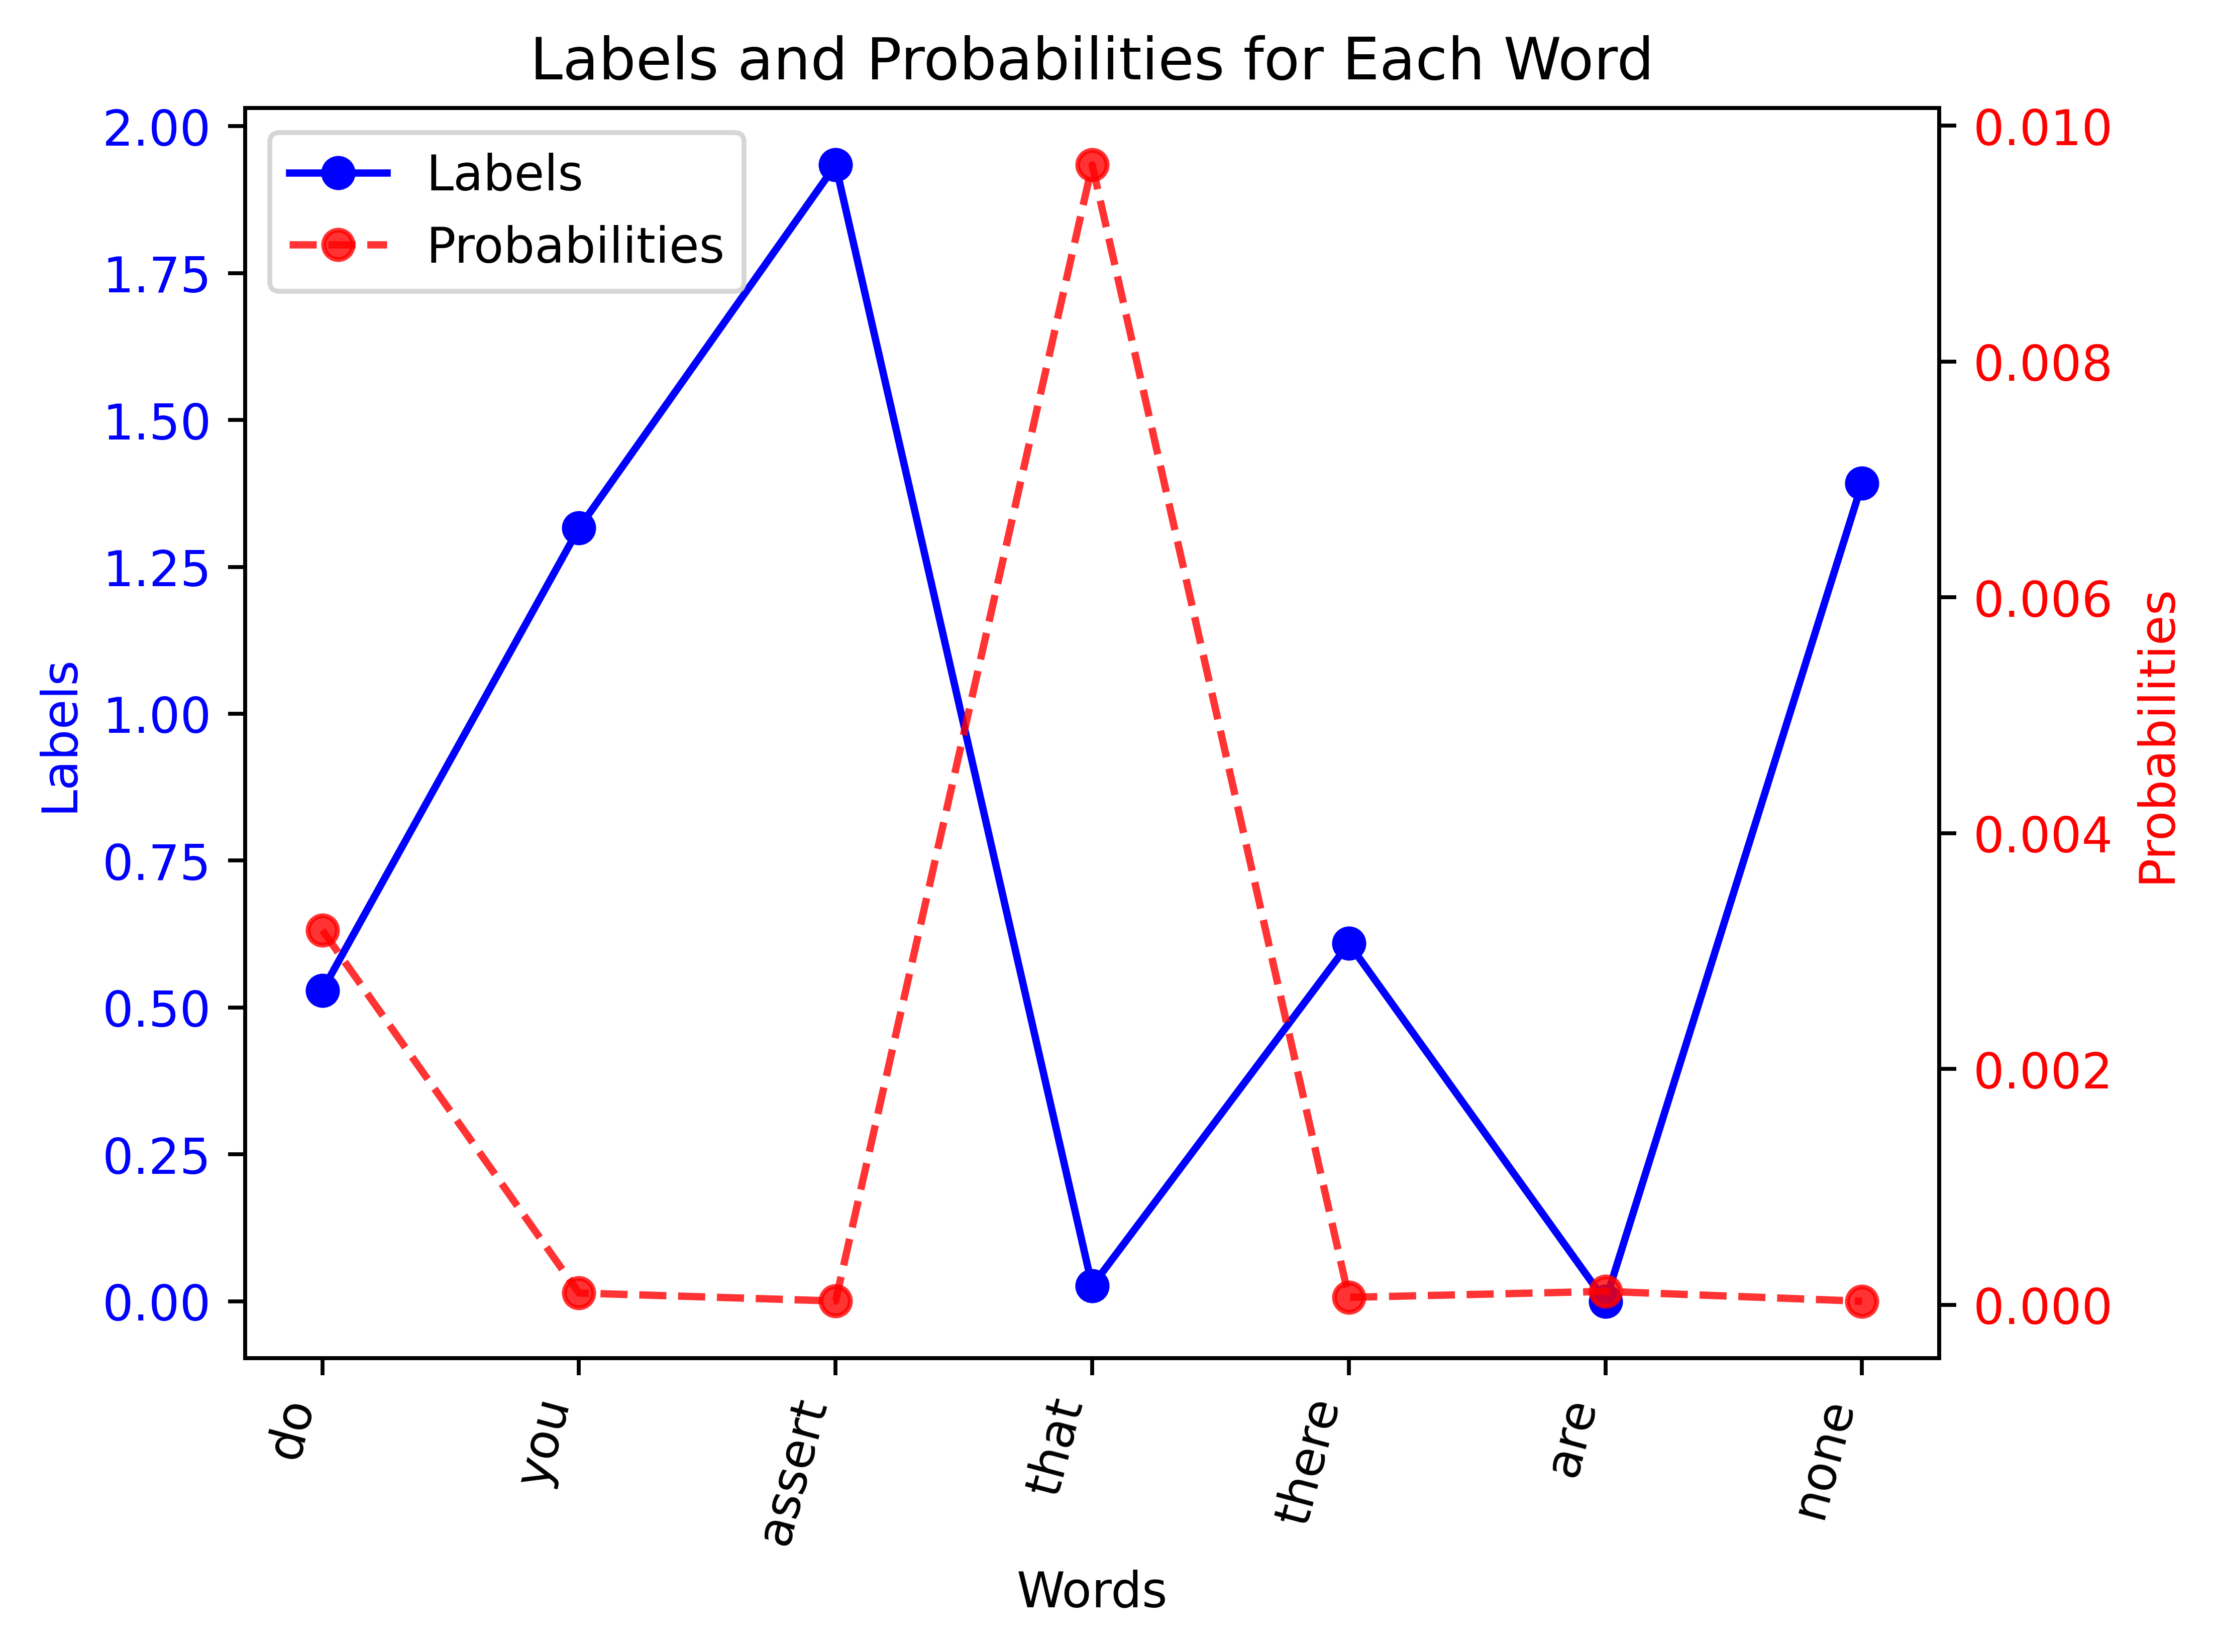

In [ ]:
from src.utils.plots import plot_labels_and_probabilities

sample_id = 4222
plot_labels_and_probabilities(
    train_texts[sample_id].split(" "),
    train_labels[sample_id],
    token_probabilities[sample_id][torch.tensor(train_loss_masks[sample_id]) == 1],
)

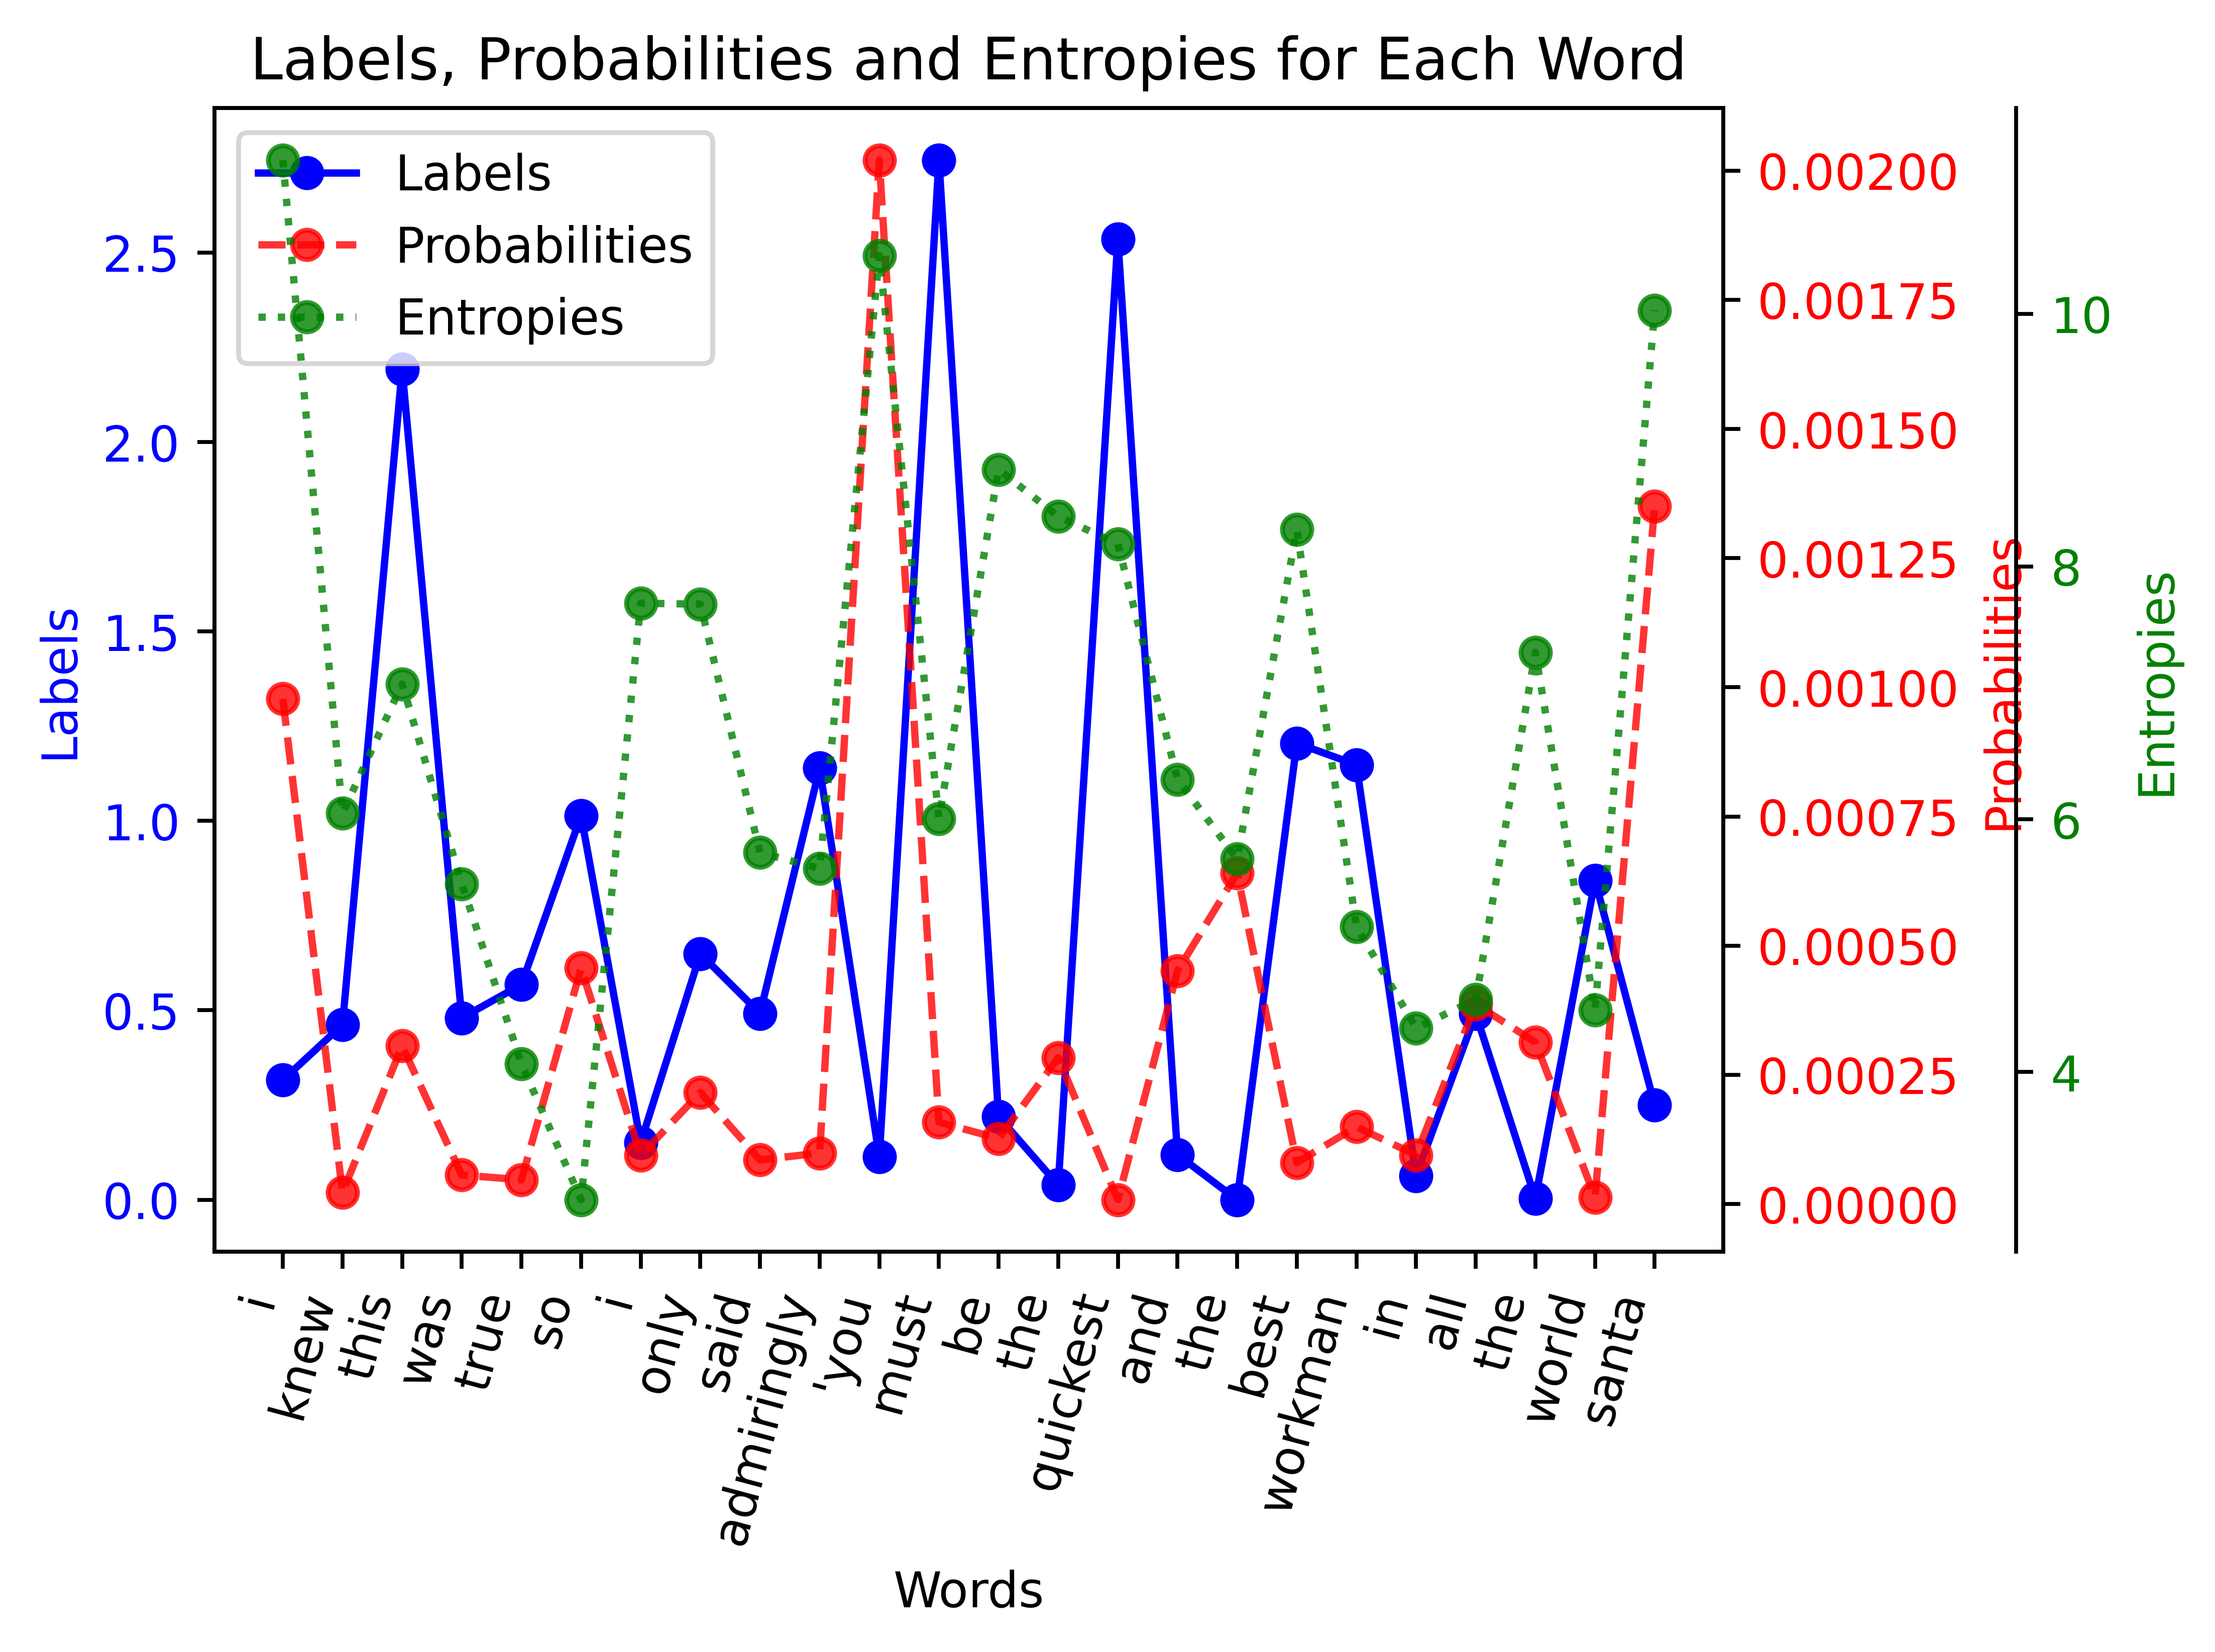

In [ ]:
from src.utils.plots import plot_labels_probabilities_entropies

sample_id = 112
plot_labels_probabilities_entropies(
    train_texts[sample_id].split(" "),
    train_labels[sample_id],
    token_probabilities[sample_id][torch.tensor(train_loss_masks[sample_id]) == 1],
    token_entropies[sample_id][torch.tensor(train_loss_masks[sample_id]) == 1],
)